In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
sn.set()
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
seg_df=pd.read_csv("segmentation data.csv")
segment_df=seg_df.drop("ID",axis=1)
segment_df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


## PCA with clustering

In [3]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [4]:
x_scaled=scaler.fit_transform(segment_df)
x_scaled.shape

(2000, 7)

In [5]:
from sklearn.decomposition import PCA
pca=PCA()

In [6]:
pca.fit(x_scaled)

PCA()

In [7]:
eigvalues=pca.explained_variance_
eigvalues

array([2.49999294, 1.83848387, 1.31813707, 0.52930714, 0.40035601,
       0.27697405, 0.14025067])

In [8]:
ratio=pca.explained_variance_ratio_
ratio

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

In [9]:
ratio_cum=np.cumsum(ratio)
ratio_cum

array([0.35696328, 0.61947251, 0.80768365, 0.88326115, 0.94042627,
       0.97997421, 1.        ])

In [13]:
d=np.argmax(ratio_cum >=0.80)+1
d

3

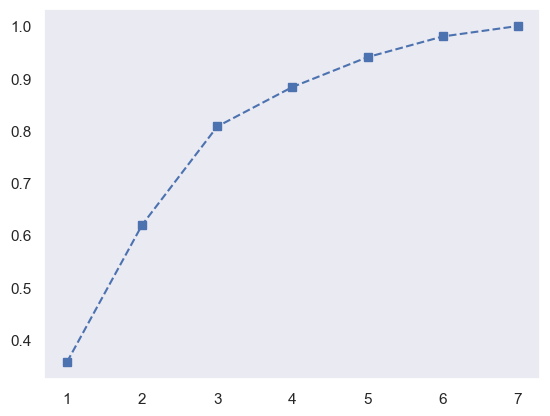

In [12]:
plt.plot(ratio_cum,'s--')
plt.xticks(list(range(0,len(ratio))),list(range(1,len(ratio)+1)))
plt.grid()
plt.show()

In [14]:
# We will be selecting 3 components that preserves 80% of the explained variance in the data
pca=PCA(n_components=3,random_state=42)

In [18]:
new_df=pd.DataFrame(pca.fit_transform(x_scaled))
new_df.head(5)

,0,1,2
0,2.514746,0.834122,2.174806
1,0.344935,0.598146,-2.211603
2,-0.651063,-0.680093,2.280419
3,1.714316,-0.579927,0.730731
4,1.626745,-0.440496,1.244909


In [19]:
pca.components_ponents_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [24]:
df_pca_comp = pd.DataFrame(data = pca.components_, columns =segment_df.columns.values, 
                          index = ['component_1', 'component_2', 'component_3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
component_1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
component_2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
component_3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


Text(0.5, 1.0, 'Loadings')

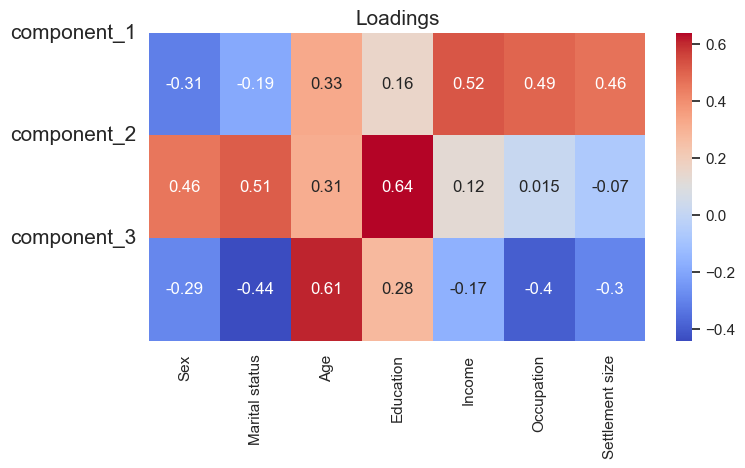

In [28]:
# Note that all fitted values are between [-1, 1], since the values are basically correlations , 
#meaning that the closer a result is to 0 the lower the loading of a variable onto a component.
plt.figure(figsize=(8,4))
sn.heatmap(df_pca_comp, cmap = 'coolwarm', annot = True)
plt.yticks([0,1,2], ['component_1', 'component_2', 'component_3'],rotation = 0, fontsize = 15 )
plt.title('Loadings',  fontsize = 15 )

* Component 1: There is a positive correlation between component 1 and age, income, occupation. and settlement size. These features are all strictly related to the career of a person. So, this component seems to show the career focused.
* Component 2: It does not show a clear picture. Sex, marital status, and education are by far the most prominent determinants. On the other hand, all career related features are almost uncorrelated with it. For this reason, this component does not refer to the career, but rather to an individual's education and lifestyle.
* Component 3: Age, marital status and occupation are the most important determinants. Marital status and occupation load negatively but are still important, because I determine the importance of the individual loadings with respect to their absolute values. So the three important aspects of the last component can indicate the experienced person has no matter if work experience or life experience.


So far, we got several ideas about what the components represent and how is the initial data related to these new features. The original data refers to the original 7 features. Therefore, it is 7 dimensional. We should transform it into 3 dimensionals.

In [30]:
from sklearn.mixture import BayesianGaussianMixture

In [31]:
bgm=BayesianGaussianMixture(n_components=10,n_init=10)

In [32]:
bgm.fit(new_df)

BayesianGaussianMixture(n_components=10, n_init=10)

In [34]:
bgm.weights_

array([0.28439621, 0.24670288, 0.01653674, 0.00050061, 0.01747987,
       0.07443795, 0.16068858, 0.03285607, 0.12641601, 0.03998507])

In [35]:
from sklearn.mixture import GaussianMixture

In [36]:
results=[]
for i in range(1,10):
    model=GaussianMixture(n_components=i, n_init=10)
    model.fit(new_df)
    bic=model.bic(new_df)
    results.append(bic)

<Axes: >

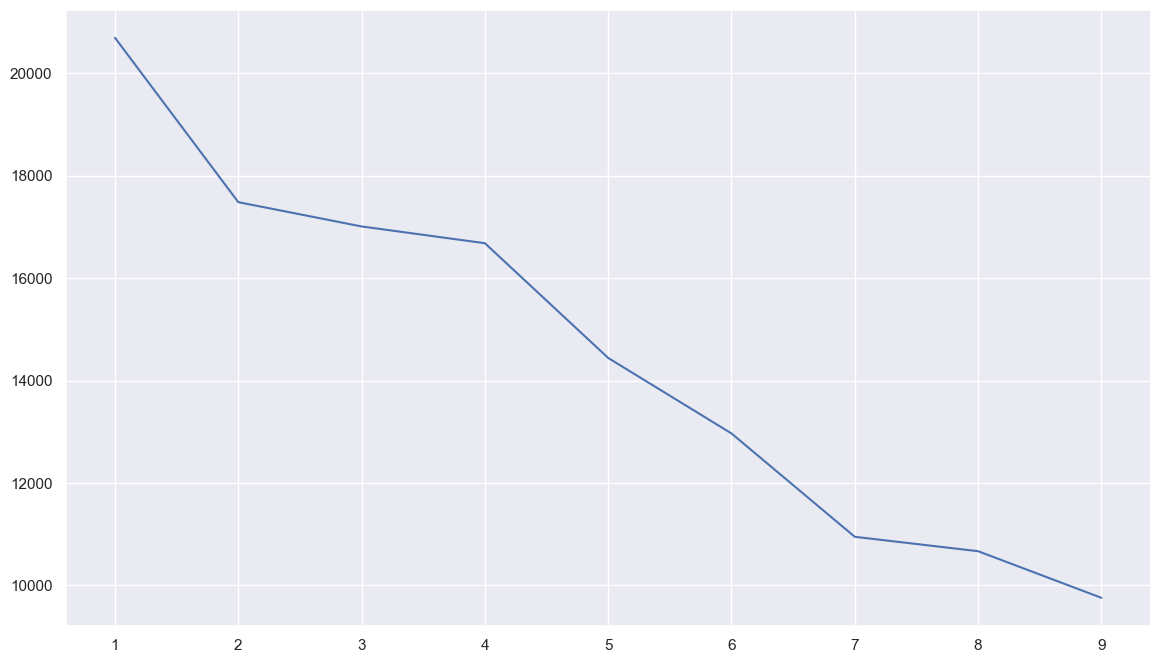

In [38]:
plt.figure(figsize=(14,8))
sn.lineplot(x=range(1,10),y=results)

In [40]:
from sklearn.cluster import KMeans
#Finding optimal number of clusters
wcss=[]
for i in range(1,10):
    model=KMeans(n_clusters=i)
    model.fit(new_df)
    iner=model.inertia_
    wcss.append(iner)

Text(0, 0.5, 'WCSS')

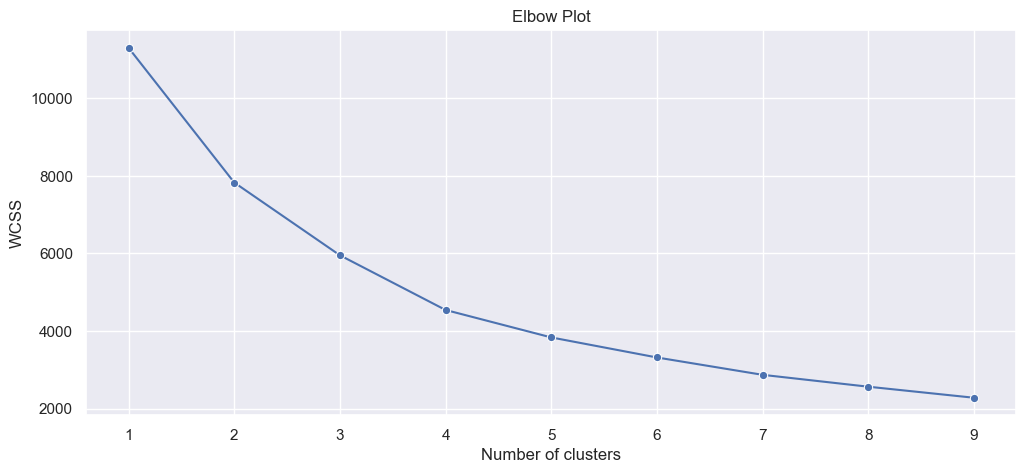

In [41]:
plt.figure(figsize=(12,5))
plt.title("Elbow Plot")
sn.lineplot(x=range(1,10),y=wcss,marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

In [42]:
from kneed import KneeLocator
x, y = list(range(1,10)), wcss
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print('The optimal number of clusters, suggested by Elbow criterion: ', kn.knee)

The optimal number of clusters, suggested by Elbow criterion:  4


In [43]:
from sklearn.neighbors import NearestNeighbors
nn=NearestNeighbors(n_neighbors=7)

In [44]:
nn.fit(new_df)

NearestNeighbors(n_neighbors=7)

In [45]:
dist,ind=nn.kneighbors(new_df)

In [46]:
dist=np.sort(dist,axis=0)

In [47]:
new_dist=dist[:,1]

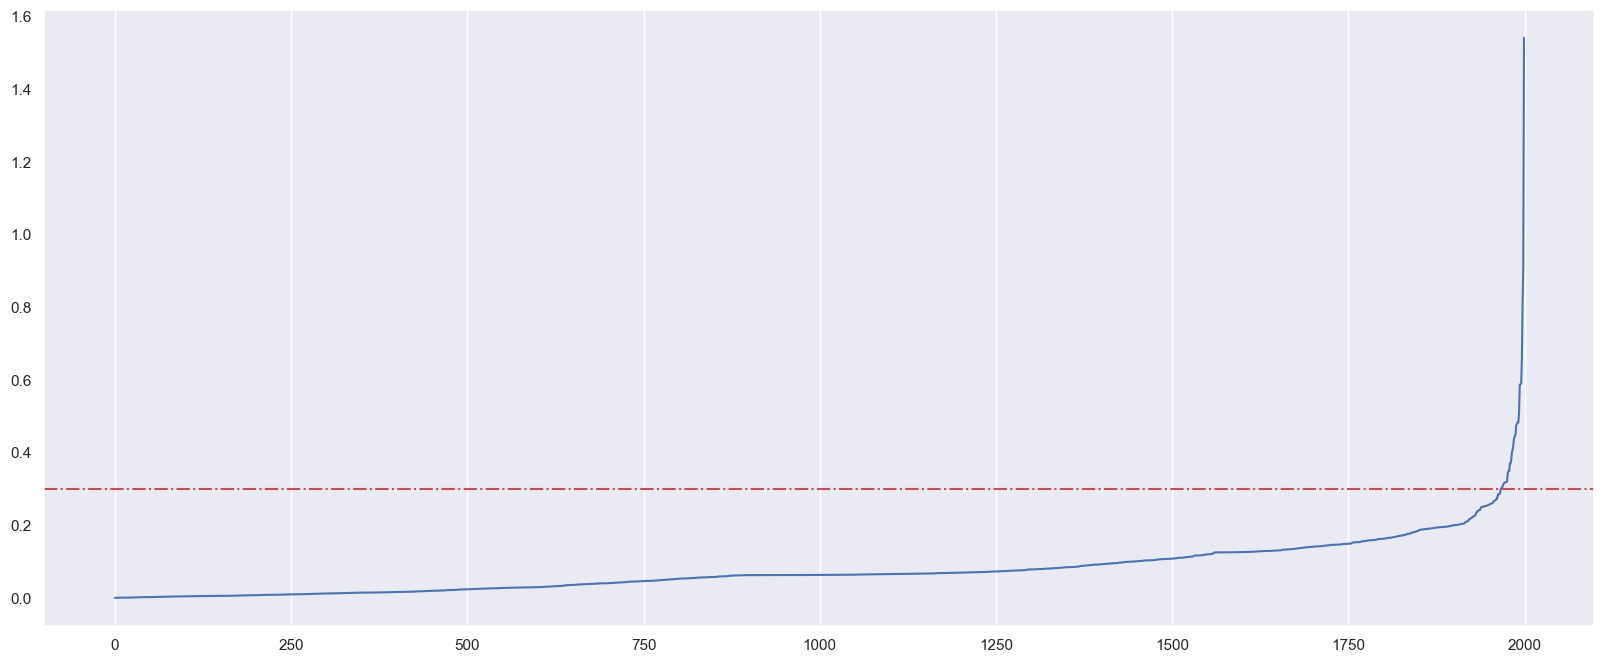

In [50]:
plt.figure(figsize=(20,8))
plt.plot(new_dist)
plt.grid(axis="y")
plt.axhline(y=0.3,color="r",ls="-.")
plt.show()

In [52]:
from sklearn.cluster import DBSCAN

In [110]:
#epsilon for DBSCAN is 0.3
# n_components for K means we will go with 4
# Gaussian mixutre also with 4 components
model_kmeans=KMeans(n_clusters=4,random_state=42)
model_dbscan=DBSCAN(eps=0.35,min_samples=15)
model_gm=GaussianMixture(n_components=4,random_state=42)

In [111]:
k_means_cluster=model_kmeans.fit_predict(new_df)
model_dbscan.fit(new_df)
gm_preds=model_gm.fit_predict(new_df)

In [112]:
pd.DataFrame(model_dbscan.labels_).iloc[:,0].nunique()

12

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

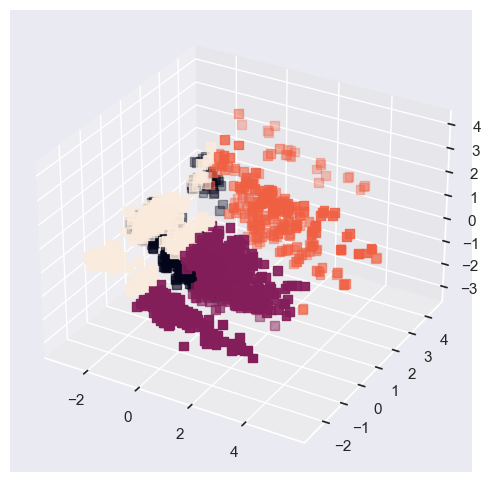

In [69]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
x = np.array(new_df.loc[:,0])
y = np.array(new_df.loc[:,1])
z = np.array(new_df.loc[:,2])
ax.scatter(x,y,z, marker="s",c=k_means_cluster, s=40)


In [83]:
import plotly.graph_objects as go
fig = go.Figure()

# Scatter plot points with cluster colors
fig.add_trace(go.Scatter3d(
    x=new_df.iloc[:, 0],
    y=new_df.iloc[:, 1],
    z=new_df.iloc[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color=k_means_cluster,
        colorscale='Viridis',  # You can choose different color scales
        opacity=0,
        symbol='circle'
    )
))

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
    ),
    scene_camera=dict(
        eye=dict(x=1.87, y=0.88, z=-0.64)
    ),
    width=800,  # Set the width of the figure
    height=600
)

# Show the interactive plot
fig.show()

In [84]:
import plotly.graph_objects as go
fig = go.Figure()

# Scatter plot points with cluster colors
fig.add_trace(go.Scatter3d(
    x=new_df.iloc[:, 0],
    y=new_df.iloc[:, 1],
    z=new_df.iloc[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color=gm_preds,
        colorscale='Viridis',  # You can choose different color scales
        opacity=0,
        symbol='circle'
    )
))

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
    ),
    scene_camera=dict(
        eye=dict(x=1.87, y=0.88, z=-0.64)
    ),
    width=800,  # Set the width of the figure
    height=600
)

# Show the interactive plot
fig.show()

<Axes: xlabel='0', ylabel='1'>

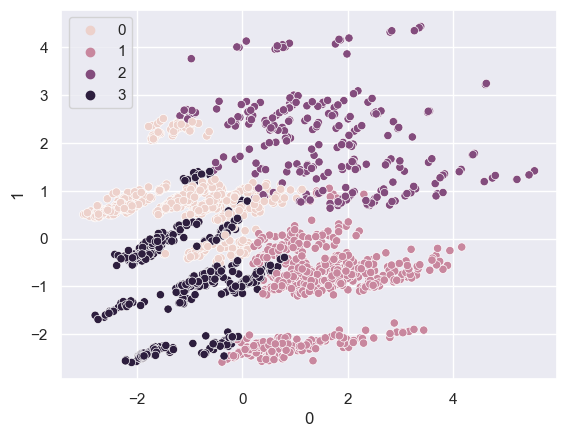

In [78]:
sn.scatterplot(x=new_df.iloc[:,0],y=new_df.iloc[:,1],hue=k_means_cluster)

<Axes: xlabel='0', ylabel='1'>

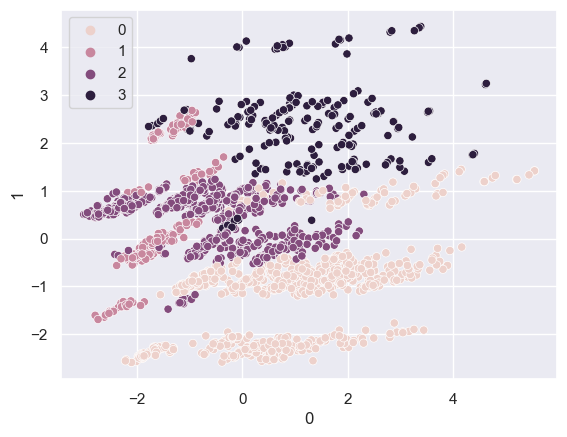

In [85]:
sn.scatterplot(x=new_df.iloc[:,0],y=new_df.iloc[:,1],hue=gm_preds)

<Axes: xlabel='0', ylabel='1'>

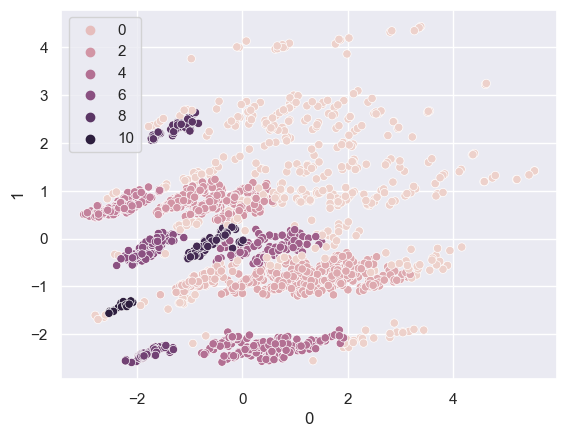

In [113]:
sn.scatterplot(x=new_df.iloc[:,0],y=new_df.iloc[:,1],hue=model_dbscan.labels_)

36